<h2 id='part1'>Project 1: Blog</h2>

Furthering the investigation to salaries, I wanted to look at the individual's characteristics such as: Gender, Education, etc

The questions that I want to answer are:
 a) Does your parents background affect your educational choices?
 b) What is the demographic of the people who responded to the survey?
 c) From the data, are there strong personal p we use it to predict salary?
 
This database - The Public 2017 Stack Overflow Developer Survey Results - is made available under the Open Database License (ODbL): http://opendatacommons.org/licenses/odbl/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: http://opendatacommons.org/licenses/dbcl/1.0/

Massive, heartfelt thanks to all Stack Overflow contributors and lurking developers of the world who took part in the survey this year. We value your generous participation more than you know.

In [207]:
#importing pakcages and reading in data from multiple sources

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

#walking through directories and removing first entry
tree = list(os.walk(os.path.join(os.getcwd(), 'StackOverflow_Data')))
tree.pop(0)
file_paths = []

for branch in tree:
    file_paths = file_paths + [os.path.join(branch[0],file) for file in branch[2]]
#for path in file_paths:
#    df=pd.read_csv(file_paths[0])
#    df=df[cols]

cols = ['CareerSatisfaction','JobSatisfaction','Respondent','Country','LanguageWorkedWith','Gender','SexualOrientation','EducationParents','RaceEthnicity','Age','ConvertedSalary','UndergradMajor','FormalEducation','YearsCoding']

df=pd.read_csv(file_paths[-1])

df_personal = df[cols]


In [162]:
#Output for first Display
df_gen=df_personal['Gender'].str.split(';',expand=True).stack().to_frame().reset_index()
df_gen=df_gen.drop(['level_0','level_1'], axis=1)
df_gen.columns=['Gender']
gender = df_gen.groupby('Gender')['Gender'].count().sort_values(ascending=False)/len(df_gen)

for tup in list(zip(list(gender.index),list(gender))):
    print(tup[0] + ": " +"{:.2%}".format(tup[1]))
    


Male: 91.68%
Female: 6.76%
Non-binary, genderqueer, or gender non-conforming: 0.91%
Transgender: 0.65%


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


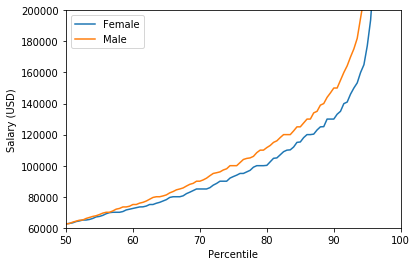

In [250]:
#df_personal['Gender2']=df_personal['Gender'].apply
#comp_areas = ['Computer science, computer engineering, or software engineering','Information systems, information technology, or system administration','Web development or web design']
#df_comp = df_personal[df_personal['UndergradMajor'].isin(comp_areas)]

#df_gen_comp=df_comp['Gender'].str.split(';',expand=True).stack().to_frame().reset_index()
#df_gen_comp=df_gen_comp.drop(['level_0','level_1'], axis=1)
#df_gen_comp.columns=['Gender']
#gender = df_gen_comp.groupby('Gender')['Gender'].count().sort_values(ascending=False)/len(df_gen_comp)

#for tup in list(zip(list(gender.index),list(gender))):
#    print(tup[0] + ": " +"{:.2%}".format(tup[1]))
#df_female = df_personal[df_personal['Gender'].apply(lambda x: True if 'Female' in x else False)]
#df_female.CareerSatisfaction.mean()
#-------------------------------------
df_female = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Female' in x else False)]
#out1=df_female.groupby('JobSatisfaction')['JobSatisfaction'].count().sort_values(ascending=False)/len(df_female)

df_male = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Male' in x else False)]
df_female = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Female' in x else False)]

female= [(i*100,df_female.ConvertedSalary.quantile(i)) for i in np.arange(0,1,0.005)]
plt.ylim((60000,200000))
plt.ylabel('Salary (USD)')
plt.xlabel('Percentile')
plt.xlim((50,100))

plt.plot([x[0] for x in female],[y[1]for y in female], label = 'Female')
male= [(i*100,df_male.ConvertedSalary.quantile(i)) for i in np.arange(0,1,0.005)]
plt.plot([x[0] for x in male],[y[1]for y in male], label = 'Male')
plt.legend(loc='upper left', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Pay_gap.png'),bbox_inches='tight')

C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


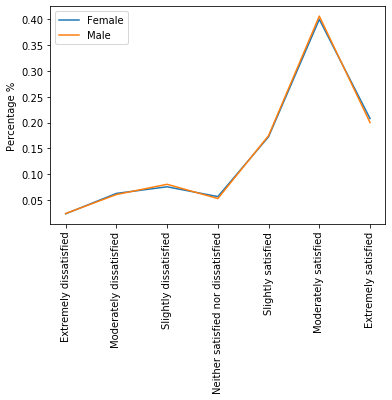

In [359]:
df_male = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Male' in x else False)]
df_female = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Female' in x else False)]

df_male['CareerSatisfaction']=df_male['CareerSatisfaction'].astype(pd.api.types.CategoricalDtype(\
                                            categories=['Extremely dissatisfied','Moderately dissatisfied',\
                                                        'Slightly dissatisfied','Neither satisfied nor dissatisfied',\
                                                        'Slightly satisfied','Moderately satisfied','Extremely satisfied'],\
                                                                                                 ordered=True))
df_female['CareerSatisfaction']=df_female['CareerSatisfaction'].astype(pd.api.types.CategoricalDtype(\
                                            categories=['Extremely dissatisfied','Moderately dissatisfied',\
                                                        'Slightly dissatisfied','Neither satisfied nor dissatisfied',\
                                                        'Slightly satisfied','Moderately satisfied','Extremely satisfied'],\
                                                                                                 ordered=True))


female= df_female.groupby('CareerSatisfaction').CareerSatisfaction.count().sort_index()/len(df_female)
male= df_male.groupby('CareerSatisfaction').CareerSatisfaction.count().sort_index()/len(df_male)

female_sort = list(zip(female.index,female))#=sorted(list(zip(female.index,female)),key = lambda x: x[0])
male_sort = list(zip(male.index,male))#sorted(list(zip(male.index,male)),key = lambda x: x[0])

#plt.xlim((50,100))
#plt.ylim((60000,200000))
plt.ylabel('Percentage %')
#plt.xlabel('Years Coding')
plt.xticks(rotation=90)

plt.plot([x[0] for x in female_sort],[y[1]for y in female_sort], label = 'Female')
plt.plot([x[0] for x in male_sort],[y[1]for y in male_sort], label = 'Male')

plt.legend(loc='upper left', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_job_satisfaction.png'),bbox_inches='tight')


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


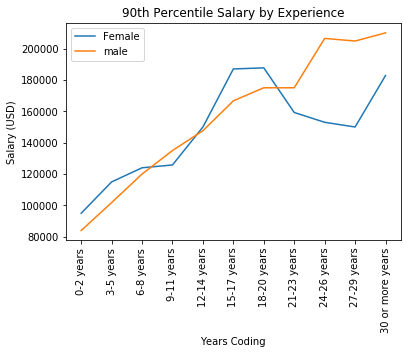

In [361]:
df_male = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Male' in x else False)]
df_female = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Female' in x else False)]



female= df_female.groupby('YearsCoding').ConvertedSalary.quantile(0.9).sort_index()
male= df_male.groupby('YearsCoding').ConvertedSalary.quantile(0.9).sort_index()

female_sort = sorted(list(zip(female.index,female)),key = lambda x: int(x[0].split()[0].split('-')[0]))
male_sort = sorted(list(zip(male.index,male)),key = lambda x: int(x[0].split()[0].split('-')[0]))
#plt.xlim((50,100))
#plt.ylim((60000,200000))
plt.title('90th Percentile Salary by Experience')
plt.ylabel('Salary (USD)')
plt.xlabel('Years Coding')
plt.xticks(rotation=90)

plt.plot([x[0] for x in female_sort],[y[1] for y in female_sort], label = 'Female')
plt.plot([x[0] for x in male_sort],[y[1] for y in male_sort], label = 'male')

plt.legend(loc='upper left', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_pay_gap_exp.png'),bbox_inches='tight')


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


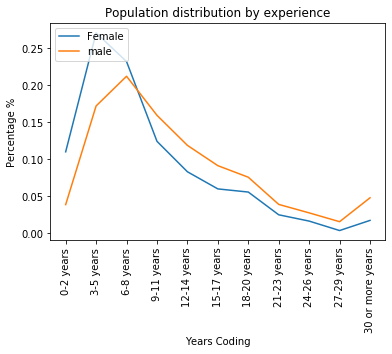

In [360]:
df_male = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Male' in x else False)]
df_female = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Female' in x else False)]


female= df_female.groupby('YearsCoding').YearsCoding.count()/len(df_female)
male= df_male.groupby('YearsCoding').YearsCoding.count()/len(df_male)

female_sort = sorted(list(zip(female.index,female)),key = lambda x: int(x[0].split()[0].split('-')[0]))
male_sort = sorted(list(zip(male.index,male)),key = lambda x: int(x[0].split()[0].split('-')[0]))
#plt.xlim((50,100))
#plt.ylim((60000,200000))
plt.title('Population distribution by experience')
plt.ylabel('Percentage %')
plt.xlabel('Years Coding')
plt.xticks(rotation=90)

plt.plot([x[0] for x in female_sort],[y[1] for y in female_sort], label = 'Female')
plt.plot([x[0] for x in male_sort],[y[1] for y in male_sort], label = 'male')

plt.legend(loc='upper left', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_pop_dist.png'),bbox_inches='tight')


In [3]:
df_personal.groupby('FormalEducation')['FormalEducation'].count().sort_values()/len(df_personal)

FormalEducation
I never completed any formal education                                                0.007081
Professional degree (JD, MD, etc.)                                                    0.014638
Primary/elementary school                                                             0.016752
Other doctoral degree (Ph.D, Ed.D., etc.)                                             0.022396
Associate degree                                                                      0.030044
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)    0.090547
Some college/university study without earning a degree                                0.118456
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           0.216438
Bachelor’s degree (BA, BS, B.Eng., etc.)                                              0.441647
Name: FormalEducation, dtype: float64

In [115]:
df_personal.isnull().mean().sort_values()

Respondent            0.000000
Country               0.004168
FormalEducation       0.042001
YearsCoding           0.050781
UndergradMajor        0.200486
LanguageWorkedWith    0.207587
Age                   0.346781
Gender                0.347843
EducationParents      0.374710
SexualOrientation     0.395428
RaceEthnicity         0.418613
ConvertedSalary       0.517455
dtype: float64

In [5]:
df_race=df_personal['RaceEthnicity'].str.split(';',expand=True).stack().to_frame().reset_index()
df_race=df_race.drop(['level_0','level_1'], axis=1)
df_race.columns=['RaceEthnicity']
df_race.groupby('RaceEthnicity')['RaceEthnicity'].count().sort_values()/len(df_personal)

RaceEthnicity
Native American, Pacific Islander, or Indigenous Australian    0.004502
Black or of African descent                                    0.016034
Middle Eastern                                                 0.024005
East Asian                                                     0.029670
Hispanic or Latino/Latina                                      0.039047
South Asian                                                    0.067129
White or of European descent                                   0.431298
Name: RaceEthnicity, dtype: float64

In [6]:
df_personal.groupby('UndergradMajor')['UndergradMajor'].count().sort_values()/len(df_personal)

UndergradMajor
A health science (ex. nursing, pharmacy, radiology)                      0.002488
I never declared a major                                                 0.007010
Fine arts or performing arts (ex. graphic design, music, studio art)     0.011481
A social science (ex. anthropology, psychology, political science)       0.013929
A humanities discipline (ex. literature, history, philosophy)            0.016084
A business discipline (ex. accounting, finance, marketing)               0.019433
Web development or web design                                            0.024460
Mathematics or statistics                                                0.028506
A natural science (ex. biology, chemistry, physics)                      0.030853
Information systems, information technology, or system administration    0.065824
Another engineering discipline (ex. civil, electrical, mechanical)       0.070254
Computer science, computer engineering, or software engineering          0.509190
N

In [7]:
df_personal.groupby('SexualOrientation')['SexualOrientation'].count().sort_values()/len(df_personal)
df_so=df_personal['SexualOrientation'].str.split(';',expand=True).stack().to_frame().reset_index()
df_so=df_so.drop(['level_0','level_1'], axis=1)
df_so.columns=['SexualOrientation']
df_so.groupby('SexualOrientation')['SexualOrientation'].count().sort_values()/len(df_personal)

SexualOrientation
Asexual                     0.011421
Gay or Lesbian              0.014415
Bisexual or Queer           0.025937
Straight or heterosexual    0.563735
Name: SexualOrientation, dtype: float64

In [8]:
df_personal.groupby('EducationParents')['EducationParents'].count().sort_values()/len(df_personal)

EducationParents
They never completed any formal education                                             0.012007
Professional degree (JD, MD, etc.)                                                    0.027566
Associate degree                                                                      0.028911
Primary/elementary school                                                             0.032715
Other doctoral degree (Ph.D, Ed.D., etc.)                                             0.037530
Some college/university study without earning a degree                                0.057812
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)    0.107875
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           0.137879
Bachelor’s degree (BA, BS, B.Eng., etc.)                                              0.182995
Name: EducationParents, dtype: float64

In [9]:
df_personal[['EducationParents','FormalEducation']]\
        .groupby(['EducationParents','FormalEducation']).size().reset_index()\
        .rename({0:'Count'}, axis = 1).sort_values('Count',ascending =False)

,EducationParents,FormalEducation,Count
10,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Bachelor’s degree (BA, BS, B.Eng., etc.)",10748
21,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Master’s degree (MA, MS, M.Eng., MBA, etc.)",5091
19,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Bachelor’s degree (BA, BS, B.Eng., etc.)",5050
55,"Secondary school (e.g. American high school, G...","Bachelor’s degree (BA, BS, B.Eng., etc.)",4441
12,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Master’s degree (MA, MS, M.Eng., MBA, etc.)",3132
64,Some college/university study without earning ...,"Bachelor’s degree (BA, BS, B.Eng., etc.)",2344
57,"Secondary school (e.g. American high school, G...","Master’s degree (MA, MS, M.Eng., MBA, etc.)",2111
17,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Some college/university study without earning ...,1821
61,"Secondary school (e.g. American high school, G...","Secondary school (e.g. American high school, G...",1584
62,"Secondary school (e.g. American high school, G...",Some college/university study without earning ...,1543


In [100]:
n=10

cols_2_test=['YearsCoding','LanguageWorkedWith','Country','EducationParents','FormalEducation','UndergradMajor','ConvertedSalary','Respondent']
seperator = ['LanguageWorkedWith','RaceEthnicity']

df_no_na=df_personal[cols_2_test].dropna()

X=df_no_na.drop(['ConvertedSalary','Respondent'], axis=1)
y=df_no_na['ConvertedSalary']

X['YearsCoding']=X['YearsCoding'].apply(lambda x : mean([float(y) for y in x.split()[0].split('-')]))

for col in X.select_dtypes(include=['object','category']).columns:
    
    if col in seperator:
        df_sep=df_personal['LanguageWorkedWith'].str.split(';',expand=True).stack().to_frame().reset_index()
        df_sep=df_sep.drop(['level_0','level_1'], axis=1)
        df_sep.columns=['LanguageWorkedWith']
        keep = list(df_lww.groupby(col)[col].count().sort_values(ascending=False).nlargest(n).index)
                  
    else:    
        keep = X.groupby(col)[col].count().sort_values(ascending=False).nlargest(n).index
        #X[col]=X[col].apply(lambda x: x if x in keep else 'other')
        
    df_ext = pd.DataFrame()
    for col2 in keep:
        df_ext[col2] = X[col].apply(lambda x: 1 if col2 in x else 0)
    
    X = pd.concat([X.drop([col],axis=1),\
                   df_ext],axis=1,sort=False)
    #mapping={}
    #i=0
    #categories = list(X[col].unique())
    #for cat in categories:
    #    mapping[cat]=i
    #    i=i+1
        
    #X[col]=X[col].apply(lambda x: mapping[x])
    
    #X=pd.concat([X.drop([col],axis=1),\
    #             pd.get_dummies(X[col],prefix=col)],axis=1, sort=False)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [101]:
reg=RandomForestRegressor()
reg.fit(X_train,y_train)

y_pred_test= reg.predict(X_test)
y_pred_train= reg.predict(X_train)

print("Test score: ",r2_score(y_test, y_pred_test))
print("Train score: ",r2_score(y_train, y_pred_train))


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test score:  -0.2177197761655736
Train score:  0.6904464175939575


In [96]:
importances = list(reg.feature_importances_)
features = list(X_train.columns)

importance_2=deepcopy(importances)
pairs = []


 
for imp in importances:
    index = importances.index(max(importance_2))
    importance_2.remove(max(importance_2))
    pairs.append((features[index],importances[index]))

    if len(pairs)> 5:
        break

            
pairs    

[('YearsCoding', 0.13857729487807743),
 ('SQL', 0.06058916755573052),
 ('Python', 0.05887010731323538),
 ('Bash/Shell', 0.057818032524725935),
 ('C#', 0.056630682861572884),
 ('PHP', 0.04724993495929332)]

In [91]:
#list(df.columns)
#df_personal.groupby('LanguageWorkedWith')['LanguageWorkedWith'].count().sort_values(ascending=False)/len(df_personal)
df_lww=df_personal['LanguageWorkedWith'].str.split(';',expand=True).stack().to_frame().reset_index()
df_lww=df_lww.drop(['level_0','level_1'], axis=1)
df_lww.columns=['LanguageWorkedWith']
list(df_lww.groupby('LanguageWorkedWith')['LanguageWorkedWith'].count().sort_values(ascending=False).nlargest(5).index)

['JavaScript', 'HTML', 'CSS', 'SQL', 'Java']

In [105]:
list(df.columns)


['Respondent',
 'Hobby',
 'OpenSource',
 'Country',
 'Student',
 'Employment',
 'FormalEducation',
 'UndergradMajor',
 'CompanySize',
 'DevType',
 'YearsCoding',
 'YearsCodingProf',
 'JobSatisfaction',
 'CareerSatisfaction',
 'HopeFiveYears',
 'JobSearchStatus',
 'LastNewJob',
 'AssessJob1',
 'AssessJob2',
 'AssessJob3',
 'AssessJob4',
 'AssessJob5',
 'AssessJob6',
 'AssessJob7',
 'AssessJob8',
 'AssessJob9',
 'AssessJob10',
 'AssessBenefits1',
 'AssessBenefits2',
 'AssessBenefits3',
 'AssessBenefits4',
 'AssessBenefits5',
 'AssessBenefits6',
 'AssessBenefits7',
 'AssessBenefits8',
 'AssessBenefits9',
 'AssessBenefits10',
 'AssessBenefits11',
 'JobContactPriorities1',
 'JobContactPriorities2',
 'JobContactPriorities3',
 'JobContactPriorities4',
 'JobContactPriorities5',
 'JobEmailPriorities1',
 'JobEmailPriorities2',
 'JobEmailPriorities3',
 'JobEmailPriorities4',
 'JobEmailPriorities5',
 'JobEmailPriorities6',
 'JobEmailPriorities7',
 'UpdateCV',
 'Currency',
 'Salary',
 'SalaryType',

In [ ]:
####Extra unused analysis



#out2=df_male.groupby('JobSatisfaction')['JobSatisfaction'].count().sort_values(ascending=False)/len(df_male)

#pd.concat([out1.apply(lambda x: "female: "+ str(x)).ix('Extremely satisfied'),out2.apply(lambda x: "male: "+ str(x))])

#out1.apply(lambda x: "female: "+ str(x)).ix('Extremely satisfied')

df_female = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Female' in x else False)]
df_male = df_personal.dropna()[df_personal.Gender.dropna(axis=0).apply(lambda x: True if 'Male' in x else False)]
#print("Female mean Salary: ",df_female.ConvertedSalary.mean())
#print("Female median Salary: ",df_female.ConvertedSalary.median())
#print("Female upper quartile Salary: ",df_female.ConvertedSalary.quantile(0.75))
#print("Female lower quartile Salary: ",df_female.ConvertedSalary.quantile(0.25))
#print("Female upper decile Salary: ",df_female.ConvertedSalary.quantile(0.9))
#print("Male mean Salary: ",df_male.ConvertedSalary.mean())
#print("male median Salary: ",df_male.ConvertedSalary.median())
#print("Male upper quartile Salary: ",df_male.ConvertedSalary.quantile(0.75))
#print("Male lower quartile Salary: ",df_male.ConvertedSalary.quantile(0.25))
#print("Male upper decile Salary: ",df_male.ConvertedSalary.quantile(0.9))

#print("Women's pay relative to her male counterpart")
#print("Mean difference: ","{:.2%}".format(((df_female.ConvertedSalary.mean())/df_male.ConvertedSalary.mean())))
#print("Upper Quartile difference: ","{:.2%}".format(((df_female.ConvertedSalary.quantile(0.75))/df_male.ConvertedSalary.quantile(0.75))))
#print("Upper Decile difference: ","{:.2%}".format(((df_female.ConvertedSalary.quantile(0.9))/df_male.ConvertedSalary.quantile(0.9))))


In [329]:
list(df_male.CareerSatisfaction.unique())

['Neither satisfied nor dissatisfied',
 'Moderately satisfied',
 'Slightly satisfied',
 'Slightly dissatisfied',
 'Extremely satisfied',
 'Moderately dissatisfied',
 'Extremely dissatisfied']

In [ ]:
['Neither satisfied nor dissatisfied',
 'Moderately satisfied',
 'Slightly satisfied',
 'Slightly dissatisfied',
 'Extremely satisfied',
 'Moderately dissatisfied',
 'Extremely dissatisfied']

In [332]:
['Extremely dissatisfied','Moderately dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied',
'Slightly satisfied','Moderately satisfied','Extremely satisfied']

['Extremely dissatisfied',
 'Moderately dissatisfied',
 'Slightly dissatisfied',
 'Neither satisfied nor dissatisfied',
 'Slightly satisfied',
 'Moderately satisfied',
 'Extremely satisfied']